In [1]:
import numpy as np
import pandas as pd

In [2]:
data_3_months = pd.read_csv("data/clean/data_3_months.csv", parse_dates=["order_purchase_timestamp"])
data_6_months = pd.read_csv("data/clean/data_6_months.csv", parse_dates=["order_purchase_timestamp"])
data_9_months = pd.read_csv("data/clean/data_9_months.csv", parse_dates=["order_purchase_timestamp"])
data_12_months = pd.read_csv("data/clean/data_12_months.csv", parse_dates=["order_purchase_timestamp"])
data_all = pd.read_csv("data/clean/data_all.csv", parse_dates=["order_purchase_timestamp"])

In [3]:
data_3_months

,order_id,order_purchase_timestamp,payment_sequential,payment_type,payment_installments,payment_value,review_score,customer_unique_id,customer_state,product_category_name
0,315ab79b5d15b5e9304d729579d36a42,2017-03-10 11:45:28,1,credit_card,3,34.86,5,c0c0c50de0f9c7089f7de06b69577afc,SP,housewares
1,d4e42f9170131eed76bf87f17541bc48,2017-03-11 14:21:09,1,credit_card,1,1.48,5,fc617e1d85eb5f935300c7943f732217,SP,housewares
2,d4e42f9170131eed76bf87f17541bc48,2017-03-11 14:21:09,2,voucher,1,33.38,5,fc617e1d85eb5f935300c7943f732217,SP,housewares
3,259ec9586950682cf8417030d1b4a6ac,2017-03-25 19:22:00,1,credit_card,3,82.84,5,059e4dfa8c1b3dd4e5179e126987f1b9,MG,housewares
4,259ec9586950682cf8417030d1b4a6ac,2017-03-25 19:22:00,1,credit_card,3,82.84,5,059e4dfa8c1b3dd4e5179e126987f1b9,MG,housewares
...,...,...,...,...,...,...,...,...,...,...
6078,c818ed0d99c7998f73659bd934936177,2017-01-25 10:09:17,1,boleto,1,69.45,5,9193694c62bc1e1927030603e0ddc905,RJ,fashio_female_clothing
6079,1c54750859f8472306a0b63d74e782ef,2017-02-25 15:37:25,1,boleto,1,105.17,1,e616b8462d4d4fadad750989fe75d0a4,SP,fashio_female_clothing
6080,9f26d6e7d343f91817f608ab2cb56cdd,2017-02-10 15:43:45,1,credit_card,2,134.00,5,eedfc8a4c7d9aa7b507ff355df8135c8,MG,fashio_female_clothing
6081,05aacaaec38544ee11d42a69bc098d4b,2017-02-26 16:03:49,1,credit_card,4,131.51,1,0a694aadb6e0baa990d23504b8cacd6d,ES,fashio_female_clothing


In [4]:
def payment_facility(df):
    df_pf = df.groupby("customer_unique_id").agg(payment_facility=("payment_installments", sum))
    for index in df_pf.index:
        if df_pf.at[index, "payment_facility"] > 1:
            df_pf.at[index, "payment_facility"] = 0
        else: 
            df_pf.at[index, "payment_facility"] = 1
    return df_pf

def category_transf(df):
    df_ct = pd.get_dummies(df[["product_category_name", "customer_unique_id"]], columns=['product_category_name'], prefix="PCat").groupby(['customer_unique_id']).sum()
    for index in df_ct.index:
        total = df_ct.loc[index].sum()
        for ptype in df_ct.columns:
            df_ct[ptype] = df_ct[ptype].astype(float)
            value = df_ct.at[index, ptype]
            frequency = round(value * 100 / total, 2)
            df_ct.at[index, ptype] = frequency
    return df_ct

def state(df):
    df_state = pd.get_dummies(df[["customer_state", "customer_unique_id"]], columns=["customer_state"], prefix="CState").groupby(["customer_unique_id"]).mean()
    return df_state

def payment(df):
    df_p = pd.get_dummies(df[["payment_type", "customer_unique_id"]], columns=['payment_type'], prefix="PType").groupby(['customer_unique_id']).sum()
    for index in df_p.index:
        total = df_p.loc[index].sum()
        for ptype in df_p.columns:
            df_p[ptype] = df_p[ptype].astype(float)
            value = df_p.at[index, ptype]
            frequency = round(value * 100 / total, 2)
            df_p.at[index, ptype] = frequency
    return df_p

def review(df):
    return df.groupby("customer_unique_id").agg(
        review_count=("review_score", "count"),
        review_min=("review_score", min),
        review_max=("review_score", max),
        review_mean=("review_score", "mean"))
    
def rfm(df):
    return df.groupby("customer_unique_id").agg(
        recency=("order_purchase_timestamp", lambda date: (df["order_purchase_timestamp"].max() - date.max()).days),
        frequency=("order_id", "count"),
        monetary=("payment_value", sum),
        value_mean=("payment_value", "mean"),
        value_min=("payment_value", min),
        value_max=("payment_value", max))

def features_engineering(df):
    df_fe = pd.concat([rfm(df), review(df), payment(df), state(df), category_transf(df), payment_facility(df)], axis=1)
    return df_fe

In [5]:
data_3_months_fe = features_engineering(data_3_months)
data_3_months_fe

,recency,frequency,monetary,value_mean,value_min,value_max,review_count,review_min,review_max,review_mean,...,PCat_security_and_services,PCat_signaling_and_security,PCat_small_appliances,PCat_sports_leisure,PCat_stationery,PCat_tablets_printing_image,PCat_telephony,PCat_toys,PCat_watches_gifts,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,20,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0
0005e1862207bf6ccc02e4228effd9a0,26,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00115fc7123b5310cf6d3a3aa932699e,68,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1
001f3c4211216384d5fe59b041ce1461,11,1,35.84,35.84,35.84,35.84,1,3,3,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
002043098f10ba39a4600b6c52fbfe3c,4,1,237.81,237.81,237.81,237.81,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffe2dd1f3b0cbf0b5f35e818ec03c49b,25,1,110.70,110.70,110.70,110.70,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ffe3e199b9d0b7fb7d2d29a5b9498447,15,1,162.10,162.10,162.10,162.10,1,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ffebb6424578e7bb153322da9d65634f,73,1,665.70,665.70,665.70,665.70,1,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [6]:
data_6_months_fe = features_engineering(data_6_months)
data_6_months_fe

,recency,frequency,monetary,value_mean,value_min,value_max,review_count,review_min,review_max,review_mean,...,PCat_security_and_services,PCat_signaling_and_security,PCat_small_appliances,PCat_sports_leisure,PCat_stationery,PCat_tablets_printing_image,PCat_telephony,PCat_toys,PCat_watches_gifts,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,111,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0
0005e1862207bf6ccc02e4228effd9a0,116,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
00115fc7123b5310cf6d3a3aa932699e,159,1,76.11,76.11,76.11,76.11,1,4,4,4.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1
0011805441c0d1b68b48002f1d005526,66,1,297.14,297.14,297.14,297.14,1,3,3,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0011857aff0e5871ce5eb429f21cdaf5,1,1,192.83,192.83,192.83,192.83,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffedff0547d809c90c05c2691c51f9b7,91,1,32.42,32.42,32.42,32.42,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
ffef0ffa736c7b3d9af741611089729b,31,1,139.07,139.07,139.07,139.07,1,5,5,5.0,...,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,1
fffcf5a5ff07b0908bd4e2dbc735a684,21,2,4134.84,2067.42,2067.42,2067.42,2,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
data_9_months_fe = features_engineering(data_9_months)
data_9_months_fe

,recency,frequency,monetary,value_mean,value_min,value_max,review_count,review_min,review_max,review_mean,...,PCat_signaling_and_security,PCat_small_appliances,PCat_small_appliances_home_oven_and_coffee,PCat_sports_leisure,PCat_stationery,PCat_tablets_printing_image,PCat_telephony,PCat_toys,PCat_watches_gifts,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,203,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0
0005e1862207bf6ccc02e4228effd9a0,209,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0006fdc98a402fceb4eb0ee528f6a8d4,73,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
000a5ad9c4601d2bbdd9ed765d5213b3,49,1,91.28,91.28,91.28,91.28,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
000bfa1d2f1a41876493be685390d6d3,0,2,93.70,46.85,46.85,46.85,2,4,5,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,49,1,102.74,102.74,102.74,102.74,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fff699c184bcc967d62fa2c6171765f7,28,1,55.00,55.00,55.00,55.00,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fffcf5a5ff07b0908bd4e2dbc735a684,113,2,4134.84,2067.42,2067.42,2067.42,2,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
data_12_months_fe = features_engineering(data_12_months)
data_12_months_fe

,recency,frequency,monetary,value_mean,value_min,value_max,review_count,review_min,review_max,review_mean,...,PCat_signaling_and_security,PCat_small_appliances,PCat_small_appliances_home_oven_and_coffee,PCat_sports_leisure,PCat_stationery,PCat_tablets_printing_image,PCat_telephony,PCat_toys,PCat_watches_gifts,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,295,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0
0000f6ccb0745a6a4b88665a16c9f078,79,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0
0004aac84e0df4da2b147fca70cf8255,46,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0
0005e1862207bf6ccc02e4228effd9a0,301,1,150.12,150.12,150.12,150.12,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0006fdc98a402fceb4eb0ee528f6a8d4,165,1,29.00,29.00,29.00,29.00,1,3,3,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffb09418989a0dbff854a28163e47c6,13,1,73.16,73.16,73.16,73.16,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,1
fffcf5a5ff07b0908bd4e2dbc735a684,205,2,4134.84,2067.42,2067.42,2067.42,2,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fffea47cd6d3cc0a88bd621562a9d061,20,1,84.58,84.58,84.58,84.58,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [9]:
data_all_fe = features_engineering(data_all)
data_all_fe

,recency,frequency,monetary,value_mean,value_min,value_max,review_count,review_min,review_max,review_mean,...,PCat_signaling_and_security,PCat_small_appliances,PCat_small_appliances_home_oven_and_coffee,PCat_sports_leisure,PCat_stationery,PCat_tablets_printing_image,PCat_telephony,PCat_toys,PCat_watches_gifts,payment_facility
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,141.90,141.90,141.90,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,27.19,27.19,27.19,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
0000f46a3911fa3c0805444483337064,541,1,86.22,86.22,86.22,86.22,1,3,3,3.0,...,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,43.62,43.62,43.62,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,196.89,196.89,196.89,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,451,2,4134.84,2067.42,2067.42,2067.42,2,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fffea47cd6d3cc0a88bd621562a9d061,266,1,84.58,84.58,84.58,84.58,1,4,4,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ffff371b4d645b6ecea244b27531430a,572,1,112.46,112.46,112.46,112.46,1,5,5,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Normalisation

In [17]:
from sklearn import preprocessing

In [18]:
standardize = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
standardize.fit(data_3_months_fe)
data_3_months_fe = standardize.transform(data_3_months_fe)

### Clustering

#### K-means

In [22]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn import decomposition
from sklearn import manifold

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

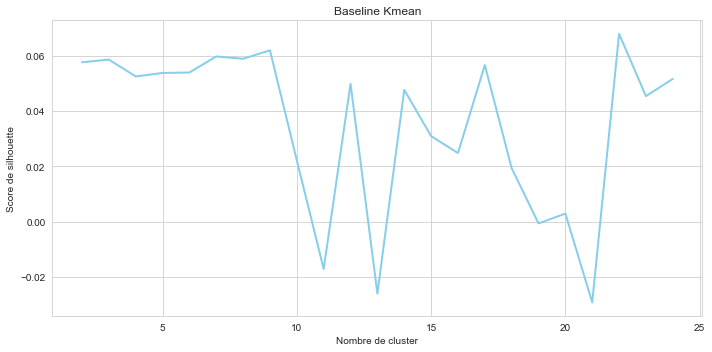

In [23]:
base_km_cluster_number = []
base_km_score = []
for n in range(2, 25):
    kmean = KMeans(n_clusters=n, n_init=100, max_iter=3000)
    kmean.fit(data_3_months_fe)
    base_km_cluster_number.append(n)
    base_km_score.append(silhouette_score(data_3_months_fe, kmean.labels_, metric='euclidean'))
    
plt.figure(figsize=(10, 5))
plt.plot(base_km_cluster_number, base_km_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("Baseline Kmean")
plt.tight_layout()
plt.show()

#### Clustering Hierarchique

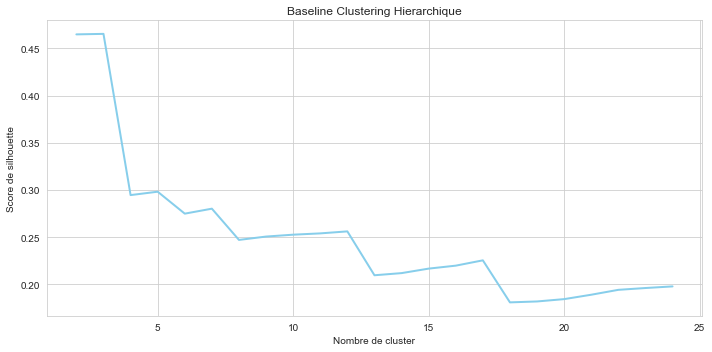

In [27]:
base_hier_cluster_number = []
base_hier_score = []
for n in range(2, 25):
    clust_hier = AgglomerativeClustering(n_clusters=n)
    clust_hier.fit(data_3_months_fe)
    base_hier_cluster_number.append(n)
    base_hier_score.append(silhouette_score(data_3_months_fe, clust_hier.labels_, metric="euclidean"))

plt.figure(figsize=(10, 5))
plt.plot(base_hier_cluster_number, base_hier_score, color="skyblue", lw=2)
plt.xlabel("Nombre de cluster")
plt.ylabel("Score de silhouette")
plt.title("Baseline Clustering Hierarchique")
plt.tight_layout()
plt.show()